In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import glob

tf.__version__

'2.0.0'

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
train_data = (train_data.astype(np.float32).reshape([-1, 28, 28, 1]) - 127.5)/127.5
test_data = (test_data.astype(np.float32).reshape([-1, 28, 28, 1]) - 127.5)/127.5

In [4]:
print(train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [5]:
batch_size =256
buffer_size = 60000

In [6]:
dataset_train = tf.data.Dataset.from_tensor_slices(train_data)
dataset_test = tf.data.Dataset.from_tensor_slices(test_data)

In [7]:
dataset_train

<TensorSliceDataset shapes: (28, 28, 1), types: tf.float32>

In [8]:
dataset_train = dataset_train.shuffle(buffer_size).batch(batch_size)
dataset_test = dataset_test.batch(batch_size)

In [9]:
def Generator():
    model = tf.keras.models.Sequential(layers=[

        tf.keras.layers.Dense(256, input_shape=(100,), use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Dense(512, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Dense(28*28*1, use_bias=False, activation='tanh'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Reshape((28, 28, 1)),
    ])
    return model

In [10]:
def Discriminator():
    model = tf.keras.models.Sequential(layers=[

        tf.keras.layers.Flatten(input_shape=[28, 28, 1,]),
        
        tf.keras.layers.Dense(512, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Dense(256, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Dense(1),

    ])
    return model

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def Discriminator_loss(real_image, gen_image):
    read_loss = cross_entropy(tf.ones_like(real_image), real_image)
    gen_loss = cross_entropy(tf.zeros_like(gen_image), gen_image)
    return read_loss + gen_loss

In [13]:
def Generator_loss(gen_image):
    return cross_entropy(tf.ones_like(gen_image), gen_image)


In [14]:
gen_opt = tf.keras.optimizers.Adam(0.01)
dis_opt = tf.keras.optimizers.Adam(0.01)

In [15]:
epochs = 100
noise_dim = 100
num_exp_gen = 16
seed = tf.random.normal(shape=[num_exp_gen, noise_dim])

In [16]:
gen = Generator()

In [17]:
dis = Discriminator()

In [18]:
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25600     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               4

In [19]:
dis.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401408    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131072    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)              

In [20]:
def train_step(images):
    noise = tf.random.normal(shape=[num_exp_gen, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        real_out = dis(images, training=True)

        gen_image = gen(noise, training=True)
        gen_out = dis(gen_image, training=True)

        gen_loss = Generator_loss(gen_out)
        dis_loss = Discriminator_loss(real_out, gen_out)
    
    grad_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
    grad_dis = dis_tape.gradient(dis_loss, dis.trainable_variables)

    gen_opt.apply_gradients(zip(grad_gen, gen.trainable_variables))
    dis_opt.apply_gradients(zip(grad_dis, dis.trainable_variables))

        

In [34]:
def gen_plot_image(gen_model, test_noise):
    pre_images = gen_model(test_noise, training=False)
    print(pre_images.shape)
    for i in range(len(pre_images)):
        plt.subplot(4, 4, i+1)
        plt.imshow((pre_images[i, :, :, 0] + 1)/2, cmap='gray')

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        gen_plot_image(gen, seed)

(16, 28, 28, 1)
(16, 28, 28, 1)
(16, 28, 28, 1)
(16, 28, 28, 1)
(16, 28, 28, 1)
(16, 28, 28, 1)
(16, 28, 28, 1)
(16, 28, 28, 1)


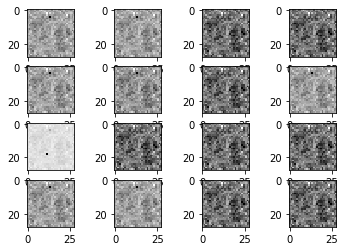

In [38]:
train(dataset_train, epochs=8)